# MolDiff 3D Training Script

This notebook shows how to train a 3D molecular diffusion model, MolDiff. MolDiff is designed to generate 3D molecular structures using a graph neural network (GNN) based diffusion model, while maintaining E(3) equivariance. The model is trained on the QM9 dataset, which contains small organic molecules with up to 9 heavy atoms.

"In this notebook, we move from 2D molecular graphs to 3D molecular generation. Unlike the 2D model that only generates atom and bond types, this 3D diffusion model generates both atom features and 3D atomic coordinates simultaneously. The key innovation is using E(3)-equivariant Graph Neural Networks (GNNs) that are specifically designed to handle 3D data while being invariant to rotations and translations, ensuring the generated molecules have a valid geometry."


##  Key Concepts:
- **E(3) Equivariance**: The model respects the symmetries of 3D space, meaning that rotations and translations of the input lead to corresponding transformations in the output.
- **Graph Neural Networks (GNNs)**: The model uses GNNs to process molecular graphs, capturing the relationships between atoms and bonds.
- **DDPM (Denoising Diffusion Probabilistic Models)**: A type of generative model that learns to reverse a diffusion process, enabling the generation of high-quality samples.
- **QM9 Dataset**: A widely used benchmark dataset for molecular machine learning, containing 134k small organic molecules with up to 9 heavy atoms (C, O, N, F).

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import logging
import os
from tqdm import tqdm
from pathlib import Path
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import the refactored components
from mol_diff_3d.data.datasets import Qm9MolecularDataset
from mol_diff_3d.models.diffusion import MolecularDiffusionModel
from mol_diff_3d.models.noise_scheduler import NoiseScheduler
from mol_diff_3d.sampling.samplers import DDPMQSampler
from mol_diff_3d.training.trainer import DDPMTrainer
from mol_diff_3d.utils.checkpoints import save_checkpoint

In [10]:
# Set up logging and device
logging.basicConfig(level=logging.INFO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Paths for saving models and results
RESULTS_DIR = Path("../results/mol_diff_3d")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Define the checkpoint path within the results directory
checkpoint_path = RESULTS_DIR / "mol_diff_final.pth"

## QM9 dataset

The QM9 dataset provides us with 3D molecular structures. We can see that each node now has a new feature: pos, a 3-dimensional vector representing its x, y, z coordinates. This is the continuous data we will add noise to and subsequently denoise.

In [12]:
# Data Loading and Preparation

# Load the QM9 dataset
dataset = Qm9MolecularDataset(max_atoms=25)

# Get dataset info
info = dataset.get_dataset_info()
print("--- Dataset Information ---")
for key, value in info.items():
    print(f"{key}: {value}")

# Create a DataLoader
dataloader = dataset.create_dataloader(batch_size=64, shuffle=True, max_samples=5000)

# Inspect a sample batch
sample_batch = next(iter(dataloader))
print("\n--- Sample Batch Information ---")
print(f"Number of molecules in batch: {sample_batch.num_graphs}")
print(f"Atom features shape (x): {sample_batch.x.shape}")
print(f"3D positions shape (pos): {sample_batch.pos.shape}")
print(f"Edge index shape: {sample_batch.edge_index.shape}")


INFO:mol_diff_3d.data.datasets:Loading DeepChem dataset: QM9
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:mol_diff_3d.data.datasets:Loaded DiskDataset with 105576 molecules
INFO:mol_diff_3d.data.datasets:Converting 5000 molecules to graphs...
INFO:mol_diff_3d.data.datasets:Processed 0/5000 molecules...


--- Dataset Information ---
name: qm9
size: 105576
max_atoms: 25
atom_feature_dim: 11


INFO:mol_diff_3d.data.datasets:Successfully converted 4980/5000 molecules (99.6%)
INFO:mol_diff_3d.data.datasets:Failed conversions: 20



--- Sample Batch Information ---
Number of molecules in batch: 64
Atom features shape (x): torch.Size([1159, 11])
3D positions shape (pos): torch.Size([1159, 3])
Edge index shape: torch.Size([2, 2378])


/home/jantine/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Model Architecture

The core of our model is the E(3)-equivariant GNN. Think of it as a special kind of GNN that has 'spatial awareness.' While a normal GNN would see two identical molecules in different orientations as different graphs, an E(3)-equivariant GNN recognizes them as the same. It ensures that if we rotate a molecule, its representation and the final generated molecule also rotate in the exact same way.  This is critical for generating chemically valid 3D structures.

In [13]:
# Set hyperparameters
config = {
    'atom_dim': info['atom_feature_dim'],
    'pos_dim': 3,
    'hidden_dim': 128,
    'time_dim': 128,
    'num_timesteps': 1000,
    'learning_rate': 1e-4,
    'epochs': 100,
    'log_interval': 10
}

In [14]:
# Initialize model and components
noise_scheduler = NoiseScheduler(num_timesteps=config['num_timesteps']).to(device)
q_sampler = DDPMQSampler(noise_scheduler.get_parameters())
model = MolecularDiffusionModel(
    atom_dim=config['atom_dim'],
    pos_dim=config['pos_dim'],
    hidden_dim=config['hidden_dim'],
    time_dim=config['time_dim']
).to(device)

optimizer = AdamW(model.parameters(), lr=config['learning_rate'])

# Initialize the trainer
trainer = DDPMTrainer(
    model=model,
    q_sampler=q_sampler,
    optimizer=optimizer,
    device=device,
    config=config
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainer ready to begin training for {config['epochs']} epochs.")

Model parameters: 333,970
Trainer ready to begin training for 100 epochs.


In [15]:
# Train the model
losses = trainer.train(dataloader, num_epochs=config['epochs'])

Starting training on cuda
Model parameters: 333,970


100%|██████████| 78/78 [00:02<00:00, 35.64it/s]


Epoch [0/100], Loss: 1.8631


100%|██████████| 78/78 [00:01<00:00, 39.31it/s]


Epoch [10/100], Loss: 1.0818


100%|██████████| 78/78 [00:02<00:00, 32.30it/s]


Epoch [20/100], Loss: 1.0624


100%|██████████| 78/78 [00:02<00:00, 38.71it/s]


Epoch [30/100], Loss: 1.0568


100%|██████████| 78/78 [00:02<00:00, 36.17it/s]


Epoch [40/100], Loss: 1.0465


100%|██████████| 78/78 [00:02<00:00, 38.20it/s]


Epoch [50/100], Loss: 1.0389


100%|██████████| 78/78 [00:02<00:00, 33.33it/s]


Epoch [60/100], Loss: 1.0368


100%|██████████| 78/78 [00:02<00:00, 37.27it/s]


Epoch [70/100], Loss: 1.0361


100%|██████████| 78/78 [00:02<00:00, 36.37it/s]


Epoch [80/100], Loss: 1.0345


100%|██████████| 78/78 [00:02<00:00, 34.50it/s]


Epoch [90/100], Loss: 1.0333


100%|██████████| 78/78 [00:02<00:00, 36.17it/s]

Training completed!


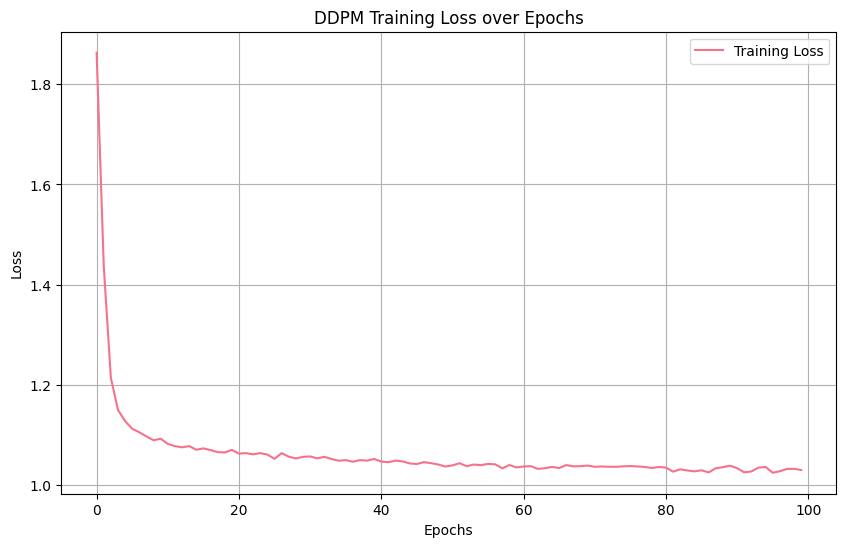

INFO:mol_diff_3d.utils.checkpoints:Checkpoint saved to ../results/mol_diff_3d/mol_diff_final.pth


In [16]:
# Visualize Loss and Save Checkpoints

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(trainer.losses, label="Training Loss")
plt.title("DDPM Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Save the final model checkpoint
os.makedirs("checkpoints", exist_ok=True)
save_checkpoint(
    filepath=checkpoint_path,
    model=model,
    optimizer=optimizer,
    epoch=trainer.epoch,
    loss=np.mean(trainer.losses[-10:]), # Average of last 10 epochs
    metrics={}
)